In [1]:
#import external libraries
import pandas as pd
import os
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
import statsmodels.api as sm

#plotting
%matplotlib notebook
import seaborn as sns
sns.set_style("whitegrid")
import plot_funcs

#import my settings
from settings import *
import CleanWxData as wx

In [2]:
#plt.ioff() #this keeps plots from appearing

In [3]:
save_plots=True
save_data=True

In [4]:
#Read in data
data_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL3/"
save_dir='./figs/'+Glacier+Station+ '/trends/'

#fl="Undercatch_Adj" + Glacier+ "_Daily_Weather.csv"
fl='RainSnowFractionData_' + Glacier + Station+ '.csv'

pth=os.path.join(data_dir, fl)
dat=pd.read_csv(pth)
print("read data from "+ pth)

#Set time index
dat.Date=pd.to_datetime(dat.Date, format='%Y/%m/%d')
dat=dat.set_index('Date')

#Abbreviate precip column name
dat.rename(columns={'Precip_MeasuredWindSpeed_UndercatchAdj':'precip_adj'}, inplace=True)
#Add month column
dat['month']=dat.index.month
dat['decimal_date']=dat.index.year + (dat.index.dayofyear-1)/365

read data from Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL3/RainSnowFractionData_Wolverine990.csv


<IPython.core.display.Javascript object>


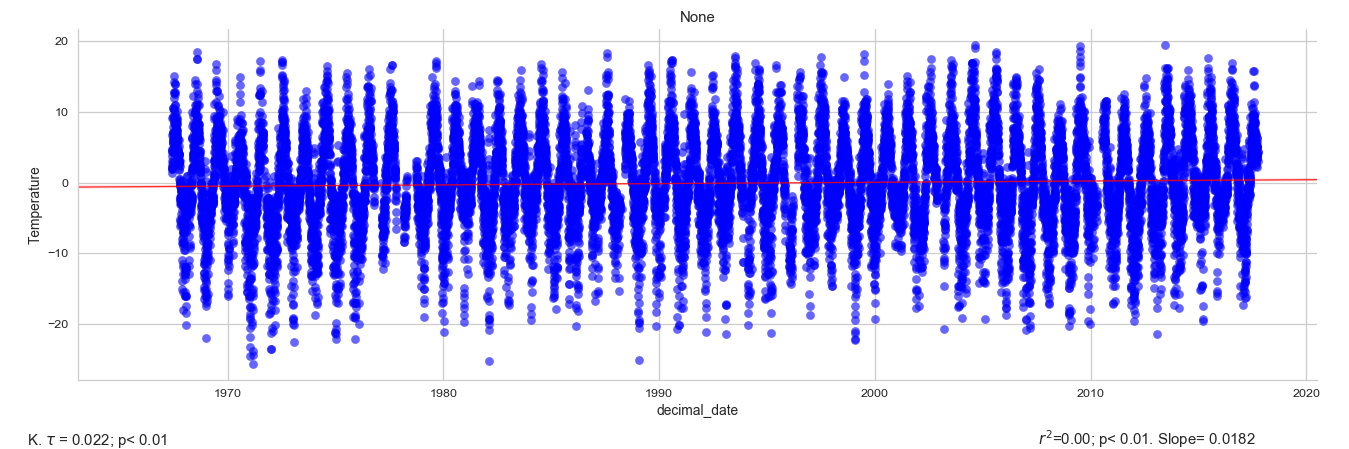

,kendall_tau,kt_pval,r2,r2_p,slope
0,0.022082,0.000015,0.001482,2.780984e-07,0.018221


In [6]:
plot_funcs.OLS_plot('decimal_date', 'Temperature', dat['1965-09':'2017-09'])

In [5]:
dat.tail(1)

,Precipitation,Temperature,phase,snow,rain,decimal_date,WindSpeed,WS_Constant,Precip_AvgWindSpeed_UndercatchAdj,precip_adj,month
Date,,,,,,,,,,,
2018-09-30,NaN,NaN,NaN,NaN,NaN,2018.745205,NaN,6.716404,NaN,NaN,9


In [6]:
#Define Seasons
summer_months=[6,7,8]
winter_months=[12,1,2]
spring_months=[3,4,5]
fall_months=[9,10,11]
May=[5]
June=[6]
July=[7]
August=[8]
Sept=[9]
season_list=[summer_months, winter_months, spring_months, fall_months]
month_list=[May, June, July, August, Sept]
season_names=['summer', 'winter', 'spring', 'fall']
month_names=['May', 'June', 'July', 'August', 'September']

In [7]:
# #Jerry Rigging for Sperry:
# season_list=month_list
# season_names=month_names

In [8]:
temp_var='Temperature'
precip_var='Precipitation'

In [9]:
#Do you want to plot an anomaly time series or measured values?
anomaly_series=False
normal_period_start, normal_period_end= '1981', '2010' #1981-2010 is from Bienek 2014

if anomaly_series==True:
    for var in [temp_var, precip_var]:
        normal_period_mean=dat.loc[normal_period_start:normal_period_end, var].mean()
        normal_period_std=dat.loc[normal_period_start:normal_period_end, var].std()
        dat[var+'_anomaly']=(dat[var]-normal_period_mean)/normal_period_std 
        var=var+ '_anomaly' #reset the variable plotted below

In [10]:
#Save original data before time subset
dat_orig=dat.copy()

#Do you want to plot for a specific time period, or whole record?
#Following McAfee 2010, 2 periods to interpret : 1950-2010; 1980-2010
time_periods=['full_period', '1980to2010', '1950to2010', '1980to2016']

if Glacier=='Sperry':
    time_periods=['full_period']

all_period_result_table=pd.DataFrame() #store all statistical results here
for time_limit in time_periods:
    print(" ")
    print("Time Limit: " + time_limit)
    if  time_limit=='1950to2010':
        dat=dat_orig['1950':'2010'].copy()
    if time_limit=='1980to2010':
        dat=dat_orig['1980':'2010'].copy()
    if time_limit=='1980to2016':
        dat=dat_orig['1980':'2016'].copy()
    if time_limit=='full_period':
        dat=dat_orig.copy()

    print("first valid index" + str(dat.Temperature.first_valid_index()))
    print("last valid index" + str(dat.Temperature.last_valid_index()))
    #Empty table to store results
    results_table=pd.DataFrame()

    #Aggregate to yearly data
    y_dat=pd.DataFrame()
    y_dat['snow']=wx.aggregate_time_with_threshold(dat['snow'], 'AS', func='sum', steps_in_period=365)
    y_dat['rain']=wx.aggregate_time_with_threshold(dat['rain'], 'AS', func='sum', steps_in_period=365)
    y_dat['snow_fraction']=y_dat.snow/(y_dat.snow+y_dat.rain)
    y_dat[precip_var]=wx.aggregate_time_with_threshold(dat[precip_var], 'AS', func='sum', steps_in_period=365)
    y_dat[temp_var]=wx.aggregate_time_with_threshold(dat[temp_var], 'AS', func='mean', steps_in_period=365)

    y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

    #Period-of-record mean yearly temperature and precip:
    print("Average Yearly Precipitation of "+ str() + str(round(y_dat.Precipitation.mean()/1000.,3))+ " m w.e.")
    print("Average Yearly Temperature of "+str(round(y_dat.Temperature.mean(),2))+ ' C')
    print("Average Yearly Snow Fraction of "+str(round(y_dat.snow_fraction.mean(),4))+ ' (fraction)')

    print("n years missing temperature: " + str(len(y_dat['1969':'2016'][y_dat['1969':'2016'].Temperature.isnull()])))

    #plot ALL-Year temperature indexes
    for ii in ['min', 'max', 'mean', 'std']:
        agg_func=ii

        y_dat[temp_var]=wx.aggregate_time_with_threshold(dat[temp_var], 'AS', func=agg_func, steps_in_period=365)

        result=plot_funcs.OLS_plot('decimal_date', temp_var, dat=y_dat.dropna(subset=[temp_var]), title='Yearly '+ temp_var + "; "+ agg_func, aspect=1.5)

        result['time_limit']=time_limit; result['season']='whole_year'
        result['agg_function']=agg_func; result['Sensor']=temp_var
        results_table=results_table.append(result)

        if save_plots:
            plt.savefig(save_dir + time_limit + '/' + Glacier + Station +'_OLS_Annual_'+ agg_func+temp_var +'.jpg')

    #plot ALL-Year Precipitation indexes
    for ii in ['sum', 'std']:
        agg_func=ii

        y_dat['Precipitation']=wx.aggregate_time_with_threshold(dat[precip_var], 'AS', func=agg_func, steps_in_period=365)
        


        result=plot_funcs.OLS_plot('decimal_date', precip_var, dat=y_dat.dropna(subset=[precip_var]), title='Yearly '+ precip_var + "; "+ agg_func, aspect=1.5)

        result['time_limit']=time_limit; result['season']='whole_year'
        result['agg_function']=agg_func; result['Sensor']=precip_var
        results_table=results_table.append(result)

        if save_plots:
            plt.savefig(save_dir + time_limit + '/' + Glacier + Station +'_OLS_Annual_'+ agg_func+precip_var +'.jpg')
            print('saving to: ' + save_dir + time_limit + '/' + Glacier + Station +'_OLS_Annual_'+ agg_func+precip_var +'.jpg')

    #Make seasonal plots of Temperature
    for ii in ['min', 'max', 'mean', 'std']:
        agg_func=ii

        for x in range(0,len(season_list)):
            season_name=season_names[x]
            season=season_list[x]    

            season_dat=dat[dat.month.isin(season)].copy() #subset to only the season
            seasonYrlydat=pd.DataFrame()
            seasonYrlydat[temp_var]=wx.aggregate_time_with_threshold(season_dat[temp_var], 'AS', func=agg_func, steps_in_period=90)
            seasonYrlydat['decimal_date']=seasonYrlydat['decimal_date']=seasonYrlydat.index.year+ (seasonYrlydat.index.dayofyear -1)/365

            print(agg_func+season_name)
            result=plot_funcs.OLS_plot('decimal_date', temp_var, dat=seasonYrlydat, title='Yearly ' +agg_func+ ' ' +season_name+ ' ' + temp_var , aspect=1.5)

            result['time_limit']=time_limit; result['season']=season_name
            result['agg_function']=agg_func; result['Sensor']=temp_var
            results_table=results_table.append(result)

            plt.savefig(save_dir + time_limit + '/' +'seasonal/' +temp_var + '/' + Glacier + Station+ '_' + season_name + '_trend_Annual_'+ agg_func+temp_var +'.jpg')

    plt.close('all')

    #Make seasonal precipitation plots
    for ii in ['max', 'mean', 'std']:
        agg_func=ii


        for x in range(0,len(season_list)):
            season_name=season_names[x]
            season=season_list[x]    

            season_dat=dat[dat.month.isin(season)].copy() #subset to only the season
            seasonYrlydat=pd.DataFrame()
            seasonYrlydat[precip_var]=wx.aggregate_time_with_threshold(season_dat[precip_var], 'AS', func=agg_func, steps_in_period=90)
            seasonYrlydat['decimal_date']=seasonYrlydat['decimal_date']=seasonYrlydat.index.year+ (seasonYrlydat.index.dayofyear -1)/365
            result=plot_funcs.OLS_plot('decimal_date', precip_var, dat=seasonYrlydat, title='Seasonal ' +agg_func+ ' ' +season_name+ ' ' + precip_var , aspect=1.5)

            result['time_limit']=time_limit; result['season']=season_name
            result['agg_function']=agg_func; result['Sensor']=precip_var
            results_table=results_table.append(result)

            plt.savefig(save_dir + time_limit + '/'+'seasonal/' +precip_var + '/' + Glacier + Station+ '_' + season_name + '_trend_Seasonal_'+ agg_func+precip_var +'.jpg')

    plt.close('all') #too many figures open

    #Snow Fraction Plots
    var='snow_fraction'
    result=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat, title='Yearly ' + var , aspect=1.5)

    result['time_limit']=time_limit; result['season']='whole_year'
    result['agg_function']='sum'; result['Sensor']=var
    results_table=results_table.append(result)

    plt.savefig(save_dir + time_limit + '/' + Glacier + Station+ '_YearlyTrend_' + var +'.jpg')

    var='snow_fraction'

    for x in range(0,len(season_list)):
        season_name=season_names[x]
        season=season_list[x]    

        season_dat=dat[dat.month.isin(season)].copy() #subset to only the season
        seasonYrlydat=pd.DataFrame()
        seasonYrlydat['snow']=wx.aggregate_time_with_threshold(season_dat['snow'], 'AS', func='sum', steps_in_period=90)
        seasonYrlydat['rain']=wx.aggregate_time_with_threshold(season_dat['rain'], 'AS', func='sum', steps_in_period=90)
        seasonYrlydat['decimal_date']=seasonYrlydat['decimal_date']=seasonYrlydat.index.year+ (seasonYrlydat.index.dayofyear -1)/365
        seasonYrlydat['snow_fraction']=seasonYrlydat.snow/(seasonYrlydat.snow+seasonYrlydat.rain)


        #Calculate snow fraction

        result=plot_funcs.OLS_plot('decimal_date', var, dat=seasonYrlydat, title='Seasonal ' +var+ ": " +season_name , aspect=1.5)
        result['time_limit']=time_limit; result['season']=season_name
        result['agg_function']='sum'; result['Sensor']=var
        results_table=results_table.append(result)

        plt.savefig(save_dir + time_limit + '/'+ 'seasonal/' +var + '/' + Glacier + Station+ '_' + season_name + '_trend_Seasonal_'+ 'sum'+var +'.jpg')

    #Save Results
    results_table.to_csv(save_dir+"/" +time_limit+ "/"+ Glacier+ Station + "_" + time_limit +"_trend_results.csv", index=False)
    results_table[results_table.kt_pval<=0.10].to_csv(save_dir+"/" +time_limit+ "/"+ Glacier+ Station + "_" + time_limit +"_FieldSig_trend_results.csv", index=False)
    all_period_result_table=all_period_result_table.append(results_table)

 
Time Limit: full_period
first valid index1967-06-01 00:00:00
last valid index2018-05-03 00:00:00
Average Yearly Precipitation of 2.15 m w.e.
Average Yearly Temperature of -0.18 C
Average Yearly Snow Fraction of 0.7623 (fraction)
n years missing temperature: 13
saving to: ./figs/Wolverine990/trends/full_period/Wolverine990_OLS_Annual_sumPrecipitation.jpg
saving to: ./figs/Wolverine990/trends/full_period/Wolverine990_OLS_Annual_stdPrecipitation.jpg
minsummer
minwinter
minspring
minfall
maxsummer
maxwinter
maxspring
maxfall
meansummer
meanwinter
meanspring
meanfall
stdsummer
stdwinter
stdspring


C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


stdfall
 
Time Limit: 1980to2010
first valid index1980-01-01 00:00:00
last valid index2010-12-31 00:00:00
Average Yearly Precipitation of 2.237 m w.e.
Average Yearly Temperature of -0.03 C
Average Yearly Snow Fraction of 0.7712 (fraction)
n years missing temperature: 9
saving to: ./figs/Wolverine990/trends/1980to2010/Wolverine990_OLS_Annual_sumPrecipitation.jpg
saving to: ./figs/Wolverine990/trends/1980to2010/Wolverine990_OLS_Annual_stdPrecipitation.jpg
minsummer
minwinter
minspring
minfall
maxsummer
maxwinter
maxspring
maxfall
meansummer
meanwinter
meanspring
meanfall
stdsummer
stdwinter
stdspring
stdfall
 
Time Limit: 1950to2010
first valid index1967-06-01 00:00:00
last valid index2010-12-31 00:00:00
Average Yearly Precipitation of 2.258 m w.e.
Average Yearly Temperature of -0.22 C
Average Yearly Snow Fraction of 0.7676 (fraction)
n years missing temperature: 13
saving to: ./figs/Wolverine990/trends/1950to2010/Wolverine990_OLS_Annual_sumPrecipitation.jpg
saving to: ./figs/Wolverine99

In [11]:
#Save Results
all_period_result_table.sort_values(['Sensor', 'agg_function','season', 'time_limit'], inplace=True) #sort
all_period_result_table.to_csv(save_dir+"/" + Glacier+ Station  +"_trend_results.csv", index=False)
all_period_result_table[all_period_result_table.kt_pval<=0.10].to_csv(save_dir+"/" + Glacier+ Station  +"_fieldSignif_trend_results.csv", index=False)
all_period_result_table[(all_period_result_table.kt_pval<=0.10) & (all_period_result_table.time_limit=='full_period')].to_csv(save_dir+"/" + Glacier+ Station  +"_fieldSignif_trend_results_full_period_only.csv", index=False)

In [12]:
#Daily Data Analysis
sensor_vars=['Precipitation', 'Temperature', 'snow', 'rain', 'WindSpeed']

#Keep all available data for trend analysis; create new table
results_table2=pd.DataFrame()
for time_limit in time_periods:
    print(" ")
    print("Time Limit: " + time_limit)
    if  time_limit=='1950to2010':
        dat=dat_orig['1950':'2010'].copy()
    if time_limit=='1980to2010':
        dat=dat_orig['1980':'2010'].copy()
    if time_limit=='1980to2016':
        dat=dat_orig['1980':'2016'].copy()
    if time_limit=='full_period':
        dat=dat_orig.copy()
    for var in sensor_vars:
        print(var)
        if dat[var].isnull().all():
            print("All " + var + " is null; skipping.")
            continue
        #Do Trend Analysis for all daily values (no aggregation to seasonal or yearly mean)
        result=plot_funcs.OLS_plot('decimal_date', var, dat=dat, title='Daily ' +var , aspect=1.5)
        
        plt.savefig(save_dir + time_limit + '/' + Glacier + Station+ '_AllDailyData_' + var +'.jpg')

        result['time_limit']=time_limit; result['season']='all available data'
        result['agg_function']='none'; result['Sensor']=var
        results_table2=results_table2.append(result)

 
Time Limit: full_period
Precipitation
Temperature
snow
rain
WindSpeed
 
Time Limit: 1980to2010
Precipitation
Temperature
snow
rain
WindSpeed
 
Time Limit: 1950to2010
Precipitation
Temperature
snow
rain
WindSpeed
 
Time Limit: 1980to2016
Precipitation


C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Temperature
snow
rain
WindSpeed


In [13]:
#Save Results
results_table2.sort_values(['Sensor', 'agg_function','season', 'time_limit'], inplace=True) #sort
results_table2.to_csv(save_dir+"/" + Glacier+ Station  +"_trend_results.csv", index=False)
results_table2[results_table2.kt_pval<=0.10].to_csv(save_dir+"/" + Glacier+ Station  +"_fieldSignif_trend_results_AllDaily.csv", index=False)
results_table2[(results_table2.kt_pval<=0.10) & (results_table2.time_limit=='full_period')].to_csv(save_dir+"/" + Glacier+ Station  +"_fieldSignif_trend_results_full_period_only_AllDaily.csv", index=False)

In [14]:
#Number of days above freezing
# Need to remove years w/ missing chunks; the aggregate ain't cutting it (False != NAN for count)
# y_dat['n_days_below_0']=wx.aggregate_time_with_threshold(dat[temp_var]<0, 'AS', func='sum', steps_in_period=365)

# result=plot_funcs.OLS_plot('decimal_date', 'n_days_below_0', dat=y_dat, title='Yearly ' +'n_days_below_0', aspect=1.5)

# for x in range(0,len(season_list)):
#     season_name=season_names[x]
#     season=season_list[x]    

#     season_dat=dat[dat.month.isin(season)].copy() #subset to only the season
#     seasonYrlydat=pd.DataFrame()
#     seasonYrlydat['n_days_below_0']=wx.aggregate_time_with_threshold(season_dat[temp_var]<0, 'AS', func='sum', steps_in_period=90)
#     seasonYrlydat['decimal_date']=seasonYrlydat['decimal_date']=seasonYrlydat.index.year+ (seasonYrlydat.index.dayofyear -1)/365
#     result=plot_funcs.OLS_plot('decimal_date', 'n_days_below_0', dat=seasonYrlydat, title='Seasonal ' +'count'+ ' ' +season_name+ ' ' + 'ndays_below_freezing' , aspect=1.5)


In [15]:
#OLS model just to check
res=sm.OLS(y_dat["Temperature"], sm.add_constant(y_dat['decimal_date']), missing='drop').fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.797
Date:                Fri, 11 May 2018   Prob (F-statistic):              0.192
Time:                        17:05:39   Log-Likelihood:                -30.427
No. Observations:                  28   AIC:                             64.85
Df Residuals:                      26   BIC:                             67.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const          -26.2803     24.546     -1.071      0.294       -76.734    24.174
decimal_date     0.0165      0.012      1.341      0.192        -0.009     0.042
==============================================================================
Omnibus:                        0.979   Durbin-Watson:                   2.359
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.953
Skew:                          -0.291   Prob(JB):                        0.621
Kurtosis:                       2.309   Cond. No.                     3.49e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
dat.tail(1)

,Precipitation,Temperature,phase,snow,rain,decimal_date,WindSpeed,WS_Constant,Precip_AvgWindSpeed_UndercatchAdj,precip_adj,month
Date,,,,,,,,,,,
2016-12-31,0.0,-1.7,snow,0.0,0.0,2017.0,6.7,8.408322,0.0,0.0,12
